# Bitcoin dominance strategy

In this notebook we will see a strategy that will rely on bitcoin dominance. When bitcoin dominance goes down, money flows into the altcoins. We will check here: <br>
    1. How related bitcoin dominance is related with price movement of altcoins <br>
    2. How profitable this strategy could have been 

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from statsmodels.tsa.stattools import coint
warnings.filterwarnings('ignore')


C:\Users\hugol\anaconda3\lib\site-packages\statsmodels\compat\pandas.py:61: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


# Load data

### crypto data

In [2]:
data = pd.read_csv("archive/coin-dance-market-cap-historical.csv")

In [3]:
data["Total Market Cap"] = data["Altcoin Market Cap"] + data["Bitcoin Market Cap"]
data["Bitcoin dominance"] = data["Bitcoin Market Cap"] / data["Total Market Cap"]
data["Label"] = pd.to_datetime(data["Label"])
data = data.rename(columns = {"Label":"date"})
data = data.set_index("date")

<AxesSubplot:xlabel='date'>

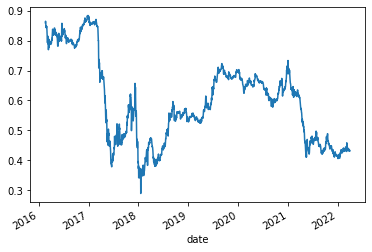

In [4]:
data["Bitcoin dominance"].plot()

### Defi data

In [5]:
data_defi_tvl = pd.read_json("archive/tvl_defi.json")
data_defi_tvl = data_defi_tvl.set_index("date")

<AxesSubplot:xlabel='date'>

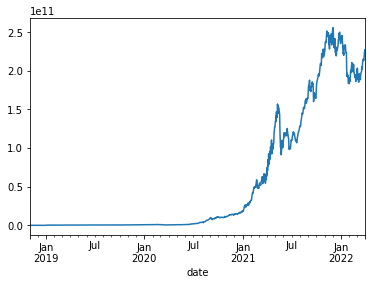

In [6]:
data_defi_tvl["totalLiquidityUSD"].plot()

### coins data

In [7]:
eth_Ticker = yf.Ticker("ETH-USD")
eth_data = eth_Ticker.history(period="max")

In [8]:
one_Ticker = yf.Ticker("ONE1-USD")
one_data = one_Ticker.history(period="max")

<AxesSubplot:xlabel='Date'>

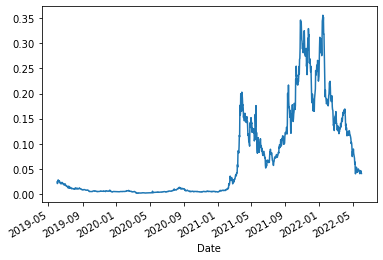

In [9]:
one_data["Close"].plot()

# Let's test for cointegration starting from june 2019, one year before defi summer

In [10]:
one_data = one_data.reset_index()
one_data = one_data[(one_data["Date"] >= "2019-06-01") & (one_data["Date"] <= "2022-03-31")]
one_data_month = one_data.copy()
one_data_month["Date"] = one_data["Date"].map(lambda x: str(x.to_pydatetime())[:7])
one_data_month = one_data_month.drop_duplicates("Date")

In [11]:
eth_data = eth_data.reset_index()
eth_data = eth_data[(eth_data["Date"] >= "2019-06-01") & (eth_data["Date"] <= "2022-03-31")]

In [12]:
data_defi_tvl = data_defi_tvl.reset_index()
data_defi_tvl = data_defi_tvl[(data_defi_tvl["date"] >= "2019-06-01") & (data_defi_tvl["date"] <= "2022-03-31")]

In [13]:
data = data.reset_index()
data = data[data["date"] >= "2019-06-01"]

<AxesSubplot:xlabel='Date'>

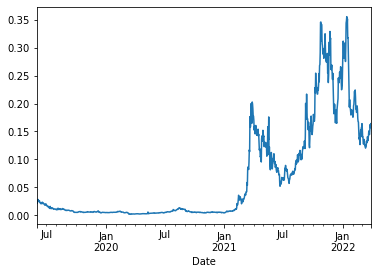

In [14]:
one_data.set_index("Date")["Close"].plot()

<AxesSubplot:xlabel='date'>

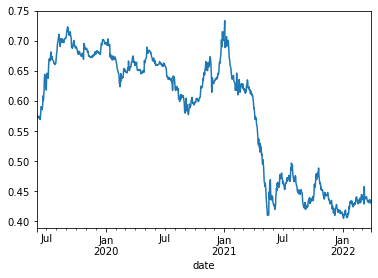

In [15]:
data.set_index("date")["Bitcoin dominance"].plot()

<AxesSubplot:xlabel='Date'>

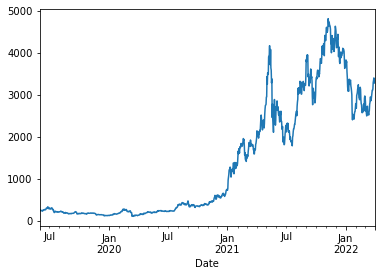

In [16]:
eth_data.set_index("Date")["Close"].plot()

### Let's first test cointegration with eth

https://github.com/simaki/cointanalysis </br>
https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.coint.html </br>
https://medium.com/bluekiri/cointegration-tests-on-time-series-88702ea9c492

In [17]:
coint_eth = coint(eth_data.set_index("Date")["Close"].to_numpy(),data.set_index("date")["Bitcoin dominance"].to_numpy())

In [18]:
print(f"The p-value for cointegration is {coint_eth[1]} which is representative at the 10% level")

The p-value for cointegration is 0.09503864632967324 which is representative at the 10% level


In [19]:
coint_one = coint(one_data.set_index("Date")["Close"].to_numpy(),data.set_index("date")["Bitcoin dominance"].to_numpy())

In [20]:
print(f"The p-value for cointegration is {coint_one[1]} which is representative at the 10% level")

The p-value for cointegration is 0.055097233389981605 which is representative at the 10% level


In [21]:
coint_defi = coint(data_defi_tvl.set_index("date")["totalLiquidityUSD"].to_numpy(),data.set_index("date")["Bitcoin dominance"].to_numpy())

In [22]:
print(f"The p-value for cointegration is {coint_defi[1]} which is representative at the 10% level")

The p-value for cointegration is 0.06772154573804745 which is representative at the 10% level


# Strategy definition

Let's consider a medium/long strategy where each time bitcoin dominance falls down of X% in a defined timeframe, we buy the asset and sell it according to a stop loss and profit

For instance if bitcoin dominance goes down 10% place a trade with stop loss of 6% and profit of 10%

In [23]:
class Trade:
    def __init__(self, price, money, btc_dominance = 0, expiry = None, profit = 0.03, loss = -0.06):
        self.price = price
        self.money = money
        self.profit = profit
        self.loss = loss
        self.number_tokens = money/price
        
    def exit_trade(self, current_price):
        price_movement = (self.price - current_price)/self.price 
        if((price_movement > self.profit) or (price_movement < self.loss)):
            return (True, current_price * self.number_tokens)
        else:
            return (False, 0)

In [61]:
bitcoin_difference = 0.01
data_asset = eth_data
trade_results = []
trade_list = []
invested_sum = 0
interval = 4


for month in range(len(data.reset_index()["date"].to_numpy())):
        #initialization
        if month == 0:
            bitcoin_dominance = data["Bitcoin dominance"].iloc[0]
            past_bitcoin_dominance = data["Bitcoin dominance"].iloc[0]
        else:
            asset_price = data_asset["Close"].iloc[month]
            #check month interval to update bitcoin significance
            if month % interval == 0:
                bitcoin_dominance = data["Bitcoin dominance"].iloc[month]
                past_bitcoin_dominance = data["Bitcoin dominance"].iloc[month - interval]
                #check if bitcoin difference is significant
                if(((bitcoin_dominance-past_bitcoin_dominance)/bitcoin_dominance) < bitcoin_difference):
                    #place trade
                    invested_sum = invested_sum + 1000
                    trade_list = np.append(trade_list, Trade(asset_price, 1000))
            
            #update trade depending on market conditions
            for trade_index in reversed(range(len(trade_list))):
                #check if trade should be exited depending on loss or profit
                trade = trade_list[trade_index]
                (res,gain) = trade.exit_trade(asset_price)
                #if trade finished add it to the list of results
                if(res):
                    trade_results = np.append(trade_results,gain)
                    trade_list = np.delete(trade_list,trade_index)
                    

In [62]:
returns = np.sum(trade_results)
print(f"The total invested is {invested_sum} and we got back {returns}, which represents {(invested_sum + (returns-invested_sum))/invested_sum -1 }% of returns")

The total invested is 200000 and we got back 202477.50053060288, which represents 0.01238750265301447% of returns
